In [44]:
library(repr)
library(tidyverse)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6, repr.plot.width = 12, repr.plot.height = 10)

In [45]:
heart_data <- read_csv(url("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"), 
                       col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", 
                                     "slope", "ca", "thal", "num"))
heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [46]:
heart_selected <- select(heart_data, age, trestbps, chol, thalach, oldpeak, num) |>
    mutate(num = case_when(num > 0 ~ 1, num == 0 ~ 0))
heart_selected

age,trestbps,chol,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,145,233,150,2.3,0
67,160,286,108,1.5,1
67,120,229,129,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮
57,130,131,115,1.2,1
57,130,236,174,0.0,1
38,138,175,173,0.0,0


In [47]:
heart_split <- initial_split(heart_selected, prop = 0.75, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [48]:
heart_sum <- heart_train |> 
    group_by(num) |> 
    summarize(count = n(), mean_age = mean(age), mean_trestbps = mean(trestbps), 
              mean_chol = mean(chol), mean_thalach = mean(thalach), mean_oldpeak = mean(oldpeak))
heart_sum

num,count,mean_age,mean_trestbps,mean_chol,mean_thalach,mean_oldpeak
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,123,52.58537,129.7317,240.6992,158.6341,0.5487805
1,104,56.70192,134.9423,255.0769,140.9231,1.5548077


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


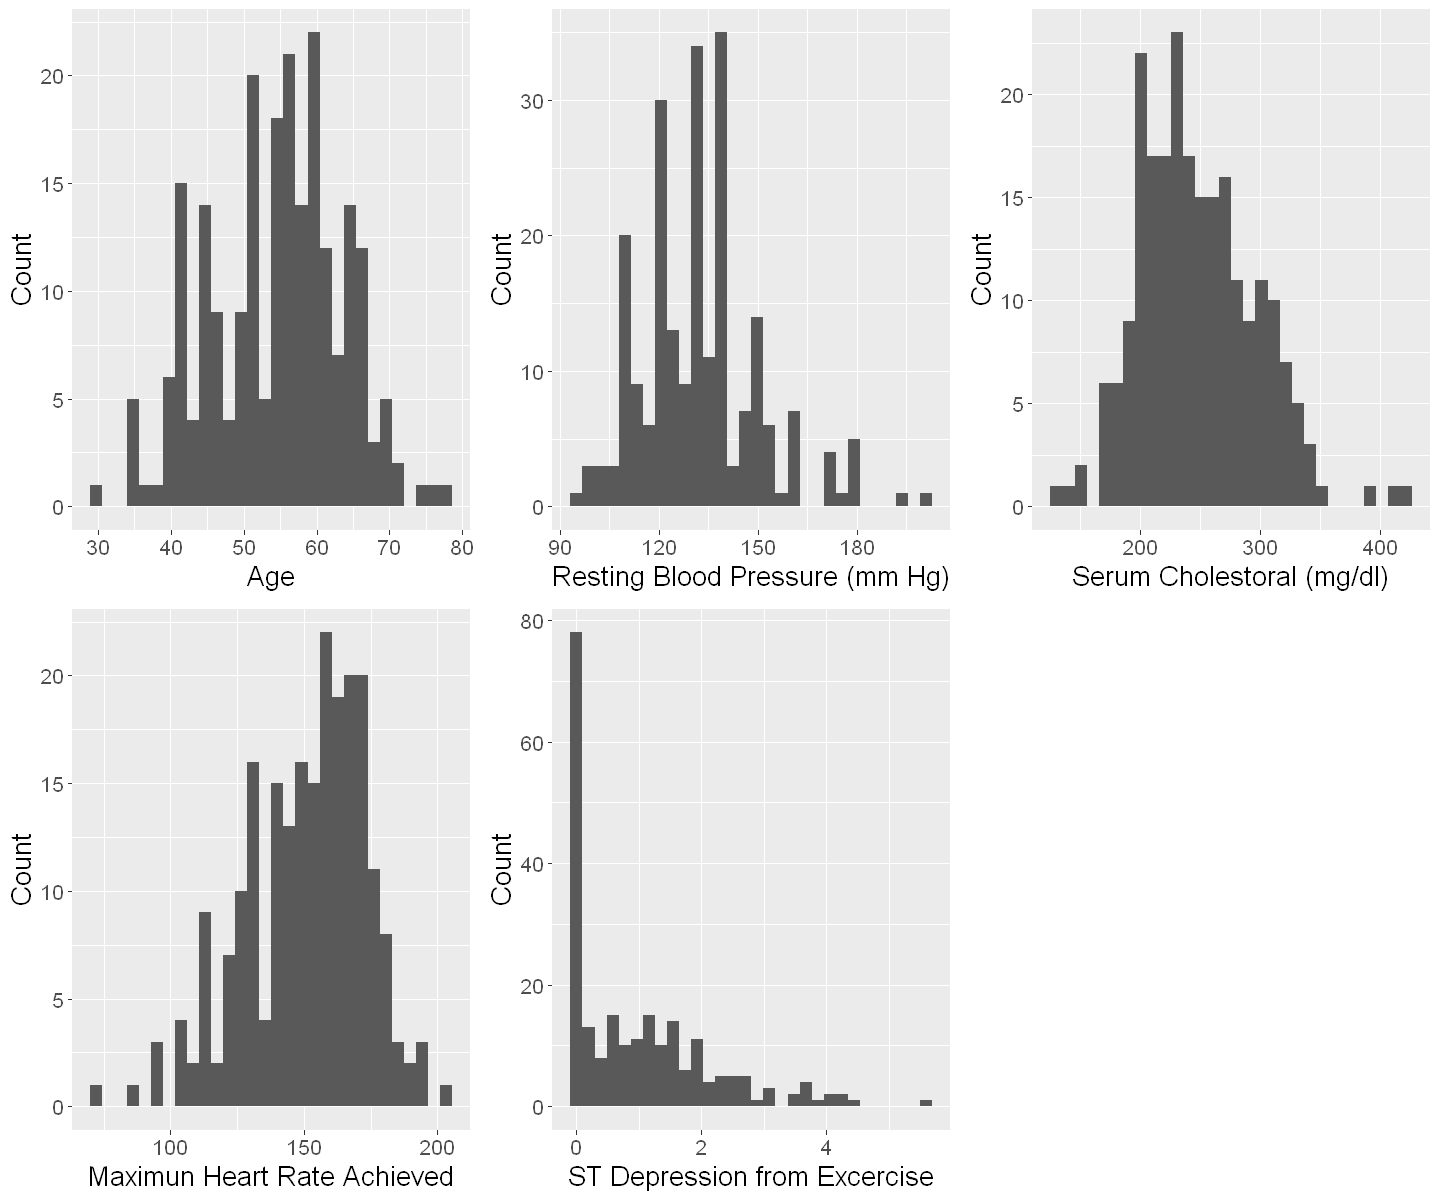

In [56]:
age_hist <- ggplot(heart_train, aes(x = age)) +
    geom_histogram() +
    labs(x = "Age", y = "Count") +
    theme(text = element_text(size=16))
trestbps_hist <- ggplot(heart_train, aes(x = trestbps)) +
    geom_histogram() +
    labs(x = "Resting Blood Pressure (mm Hg)", y = "Count") +
    theme(text = element_text(size=16)) 
chol_hist <- ggplot(heart_train, aes(x = chol)) +
    geom_histogram() +
    labs(x = "Serum Cholestoral (mg/dl)", y = "Count") +
    theme(text = element_text(size=16))
thalach_hist <- ggplot(heart_train, aes(x = thalach)) +
    geom_histogram() +
    labs(x = "Maximun Heart Rate Achieved", y = "Count") +
    theme(text = element_text(size=16))
oldpeak_hist <- ggplot(heart_train, aes(x = oldpeak)) +
    geom_histogram() +
    labs(x = "ST Depression from Excercise", y = "Count") +
    theme(text = element_text(size=16))
heart_hist <- plot_grid(age_hist, trestbps_hist, chol_hist, thalach_hist, oldpeak_hist)
heart_hist